In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

%matplotlib inline

# Single particle

Simply solve 1D Schrodinger equation using finite difference

In [2]:
def V_soft_coulomb(x, RZ_list, alpha=2, beta=0.5):
    """
    arg: x is the working space
         RZ_list is a list consist of atom position and atomic charge
         e.g. atom_list = [[R_i, Z_i]]
    out: potential energy operator V(x) where V = sum_i{-(Z_i)/(1+R_i)}
    """
    
    V = np.zeros(len(x))
    
    for Ri, Zi in RZ_list:
        V += -Zi / (1 + abs(x - Ri) ** alpha) ** beta
    
    return np.diag(V)

def T_from_x(x, periodic=True):
    """
    arg: x is the working space
    out: kinetic energy operator
    """
    D_base = np.eye(len(x))
    Da = np.roll(D_base, 1)
    Da[0,0] = 0
    Db = np.roll(D_base, -1)
    Db[-1,-1] = 0
    D2 = (Da - 2*D_base + Db)
    dx = x[1] - x[0]
    #D2[0,0] = D2[-1,-1] = -2
    
    # periodic boundary condition
    if periodic:
        D2[0,-1] = D2[-1,0] = 1

    # set kinetic energy scale
    return -0.5 * (D2 / (dx ** 2))


def ev_normalize(x, ev):
    dx = x[1] - x[0]
    return ev / np.sqrt(dx)

def solve_H_sp(x, V):
    """
    solve single particle Hamiltonian
    arg: x is the working space
         RZ_list is a list consist of atom position and atomic charge
         e.g. atom_list = [[R_i, Z_i]]
    out: list of eigenvalues, eigenvectors, and external potential energy
    """
    H = T_from_x(x) + V
    ew, ev = np.linalg.eigh(H)
    return ew, ev_normalize(x, ev), H

    

0.45243262563
1.0
[-0.68358136 -0.26872995 -0.18619731  0.15334079  0.16666206]
0.404872118535
1.0
[-0.67031692 -0.24770553 -0.17446299  0.33152132  0.33269499]
0.404426604717
1.0
[-0.67027701 -0.24629582 -0.17398254  0.34383646  0.34502724]


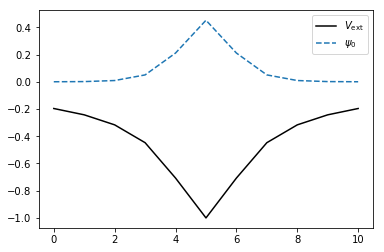

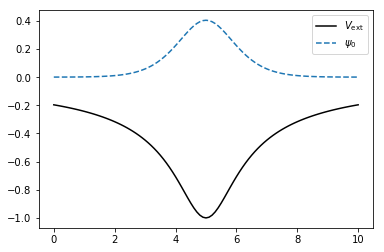

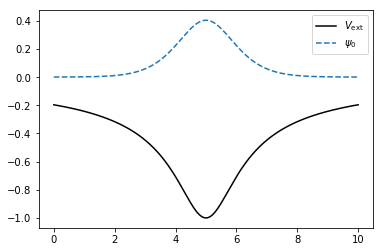

In [3]:
# senity test to see consistency with respect to different resolution
for n in [11, 101, 1001]:
    x = np.linspace(0, 10, n, endpoint=True)
    V = V_soft_coulomb(x, [[5, 1]])
    #V = np.sin(x)
    ew, ev, H = solve_H_sp(x, V)
    plt.figure()
    plt.plot(x, np.diag(V), label=r"$V_{\rm ext}$", color='k')
    plt.plot(x, ev[:,0]**2, label=r"$\psi_0$", ls='--')
    plt.legend()
    print max(ev[:,0]**2)
    # integral normalization condition
    dx = x[1] - x[0]
    print sum((ev[:,0])**2 * dx)
    print ew[:5]

[-1.0659457  -0.85184066 -0.54179489 -0.10211388 -0.0843257 ]
[-1.06601284 -0.85120175 -0.54271439 -0.09299279 -0.07574957]


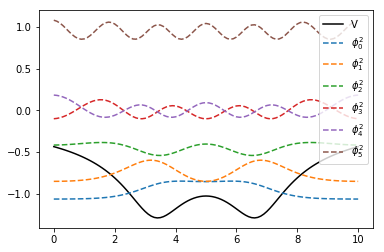

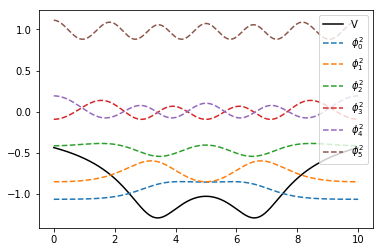

In [4]:
# senity test for final single particle solutions
x = np.linspace(0, 10, 101, endpoint=True)
V = V_soft_coulomb(x, [[3.33, 1], [6.67, 1]])
ew, ev, H = solve_H_sp(x, V)

plt.plot(x,np.diag(V), label='V', color='k')
for i in range(6):
    plt.plot(x, ev[:,i]**2 + ew[i], label=r'$\phi_{%d}^2$' % i, ls='--')   
plt.legend()
print ew[:5]

x = np.linspace(0, 10, 501, endpoint=True)
V = V_soft_coulomb(x, [[3.33, 1], [6.67, 1]])
ew, ev, H = solve_H_sp(x, V)

plt.figure()
plt.plot(x,np.diag(V), label='V', color='k')
for i in range(6):
    plt.plot(x, ev[:,i]**2 + ew[i], label=r'$\phi_{%d}^2$' % i, ls='--')   
plt.legend()
print ew[:5]

# Hartree-Fock self-consistency

Compute electron density $\rho(x) = \sum_i\psi_i^2(x)$ and the electron-electron interaction elergy including
1. Coulomb term $J(x)=\frac{1}{2}\int dx'\frac{\rho(x')}{1+|x-x'|}$
2. Exchange term $K(x)=-\sum_{ij}\int dx'\frac{\psi_i(x')\psi_j(x')}{1+|x-x'|}$
3. Or exchange-correlation term (use libxc) $E_{xc}[\rho](x)$

And reconstruct Hamiltonian by Fock matrix
$$
F(x)\psi_i(x) = \Big(-\frac{\nabla^2}{2} - \sum_I\frac{Z_I}{(1+R_{I}^{\alpha})^{\beta}} + J(x) + K(x)\Big)\psi_i(x) = \varepsilon_i\psi_i(x).
$$
The solusion is found by self-consistency procedure.

**NOTE**: Periodict boundary condition should be included in the integrals

In [5]:
def rho_from_evn(x, ev, N_by_2):
    """cacluate electron density from eigenvectors"""
    rho = np.zeros(len(x))
    for i in range(N_by_2):
        rho += ev[:, i]**2
    return rho

def J_from_rhoevn(x, rho, ev, N_by_2, alpha=2, beta=0.5):
    """compute Coulomb operator"""
    dx = x[1] - x[0]
    mid = (x[-1] - x[0]) / 2. + x[0]
    r_inv = 1. / (1 + abs(x - mid) ** alpha) ** beta
    
    J = np.zeros(len(x))
    
    for j in range(N_by_2):
        J += np.convolve(ev[:, j]**2, r_inv, 'same')
        
    return np.diag(rho * J)
    #return np.diag(J)

def K_from_rhoevn(x, rho, ev, N_by_2, alpha=2, beta=0.5):
    """compute exchange operator"""
    dx = x[1] - x[0]
    mid = (x[-1] - x[0]) / 2. + x[0]
    r_inv = 1. / (1 + abs(x - mid) ** alpha) ** beta
    
    K = np.zeros(len(x))

    # some problem here that the non-local operator is not constructed properly
    for i in range(N_by_2):
        evi = ev[:,i]
        for j in range(N_by_2):
            evj = ev[:,j]
            K += (evi * evj) * np.convolve(evi * evj, r_inv, 'same')
            #K += np.convolve(evi * evj, r_inv, 'same')
    return np.diag(K)

def E_ele(x, ev, N_by_2, T, V, J, K):
    E = 0
    for O in [2*T, 2*V, 2*J, -K]:
        E += ev[:,N_by_2].dot(O).dot(ev[:,N_by_2])
    return E

def SCF_step(x, T, V, N_by_2, ev=None, mixing=0.1, scale=0.05):
    """single SCF step iteration"""
    if ev is None:
        ew, ev, H = solve_H_sp(x, V)
    rho = rho_from_evn(x, ev, N_by_2)
    J = J_from_rhoevn(x, rho, ev, N_by_2)
    K = K_from_rhoevn(x, rho, ev, N_by_2)
    H = T + V + (2*J - K) * scale
    ew_new, ev_new = np.linalg.eigh(H)
    E = E_ele(x, ev_new, N_by_2, T, V, scale*J, scale*K)
    dx = x[1] - x[0]
    ev_new = ev_new / np.sqrt(dx)
    if mixing > 0:
        ev_new = ev*mixing + ev_new*(1-mixing)
    return ew_new, ev_new, E

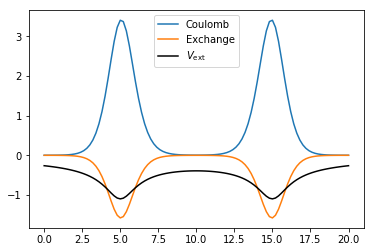

In [6]:
# visualize Coulomb/Exchange terms
# L = 20.
# N = 4
# x = np.linspace(0, L, 101, endpoint=True)
# V = V_soft_coulomb(x, [[L/3., 1], [2* L/3., 1]])

L = 20.
N = 4
x = np.linspace(0, L, 101, endpoint=True)
V = V_soft_coulomb(x, [[L/4., 1], [3* L/4., 1]])

ew, ev, H = solve_H_sp(x, V)
rho = rho_from_evn(x, ev, N/2)
J = J_from_rhoevn(x, rho, ev, N/2)
K = K_from_rhoevn(x, rho, ev, N/2)
plt.plot(x, 2*np.diag(J), label='Coulomb')
plt.plot(x, -np.diag(K), label='Exchange')
plt.plot(x, np.diag(V), label=r'$V_{\rm ext}$', color='k')
plt.legend()

[-0.77169751 -0.77061593 -0.41307442 -0.35410428]
-0.768674734497 [-0.4772759  -0.46129697 -0.36182791 -0.2651351 ]
-0.743110847664 [-0.56044495 -0.5561324  -0.33984833 -0.24517872]
-0.759611304548 [-0.50802602 -0.49836479 -0.35499788 -0.25703246]
-0.749628657984 [-0.53150219 -0.52507293 -0.34695024 -0.24872681]
-0.755428364089 [-0.51741932 -0.50919777 -0.35157683 -0.25317492]
-0.751650310598 [-0.52443396 -0.51728377 -0.34886082 -0.25019692]
-0.754160821012 [-0.5207321  -0.51294998 -0.35053229 -0.2521253 ]
-0.752374703984 [-0.52242185 -0.51503245 -0.34948845 -0.25075939]
-0.753714107742 [-0.52176332 -0.51412258 -0.35018916 -0.25177375]
-0.752655482443 [-0.52184671 -0.51437643 -0.34970306 -0.25098082]
-0.753527279087 [-0.5220474  -0.51445524 -0.35006709 -0.25163213]
-0.752785566782 [-0.52170312 -0.51420326 -0.34978445 -0.2510831 ]
-0.753429977228 [-0.52210086 -0.51452752 -0.35001699 -0.25156067]
-0.752860739851 [-0.52168793 -0.51417545 -0.34982144 -0.25114155]
-0.75336773028 [-0.5220881

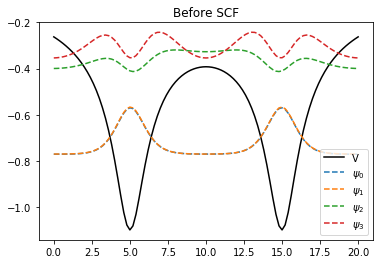

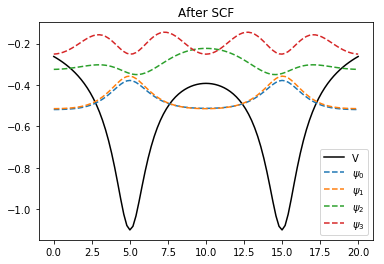

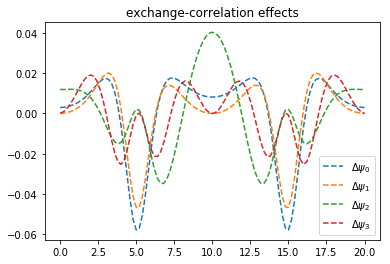

In [7]:
# system setup

# L = 15.
# N = 4
# x = np.linspace(0, L, 501, endpoint=True)
# V = V_soft_coulomb(x, [[L/3., 1], [2* L/3., 2]])
#V = V_soft_coulomb(x, [[L/2., 1]])

L = 20.
N = 4
x = np.linspace(0, L, 101, endpoint=True)
V = V_soft_coulomb(x, [[L/4., 1], [3* L/4., 1]])

T = T_from_x(x)
ew, ev, H = solve_H_sp(x, V)
ew0, ev0 = ew, ev

# plot initial system before SCF
plt.plot(x, np.diag(V), color='k', label='V')
for i in range(4):
    plt.plot(x, ev[:, i]**2 + ew[i], ls='--', label=r'$\psi_{%d}$' % i)
plt.legend(loc=4)
plt.title("Before SCF")

# SCF procedure
E_list = []
print ew[:4]
for _ in range(20): # 20 steps iteration
    # 4 electron system such that N_by_2=2
    ew, ev, E = SCF_step(x, T, V, 2, ev=ev, scale=0.3)
    E_list.append(E)
    print E, ew[:4]

# plot final system after SCF
plt.figure()
plt.plot(x, np.diag(V), color='k', label='V')
for i in range(4):
    plt.plot(x, ev[:, i]**2 + ew[i], ls='--', label=r'$\psi_{%d}$' % i)   
plt.legend(loc=4)
plt.title("After SCF")

plt.figure()
#plt.plot(x, np.diag(V), color='k', label='V')
for i in range(4):
    plt.plot(x, ev[:,i]**2 - ev0[:,i]**2, ls='--', label=r'$\Delta\psi_{%d}$' % i)
plt.legend(loc=4)
plt.title("exchange-correlation effects")

**Note**:
1. It seems there are some bugs because 1D many-particle Hartree-Fock approximation should still statisfies variational principle. But we don't have it yet in the sense that E_ele is increasing.
2. There is something strange with 1D electron-electron interaction. It seems necessary to tune down the interaction strenth to 1% in order to have electrons stay around atoms. Otherwise the Coulomb repulsion becomes too strong and push all the electron to the place with no electrons and oscilate back-and-forth through out SCF.

# Solving Schrodinger equation in reciprocal space
Let $L=a$ be the size of the 1D repeating cell. The reciprocal cell size is $b=\frac{2\pi}{a}$. Any 1D descrete function $\rho[x_j]$ over the range $0=x_0, x_1\cdots, x_{N-1}, x_N=a$ can be expressed in planewave basis using descrete Fourier transform
$$
\rho(q) = \frac{1}{L}\sum_{n=0}^{N-1}\exp(-i\frac{qn}{N})\rho(x_n) = \frac{1}{L}\sum_{n=0}^{N-1}\exp(-i\frac{qx_n}{L})\rho(x_n),
$$
where $\rho(q)$ is the component of $\exp(i\frac{qx_n}{a})$ in $\rho(x)$. 
Note that $q = \frac{2\pi n}{L}$ in this notation.

Instead of solving everything using finite difference in real space, the Fock matrix should be mapped to the reciprocal space and solve the eigenproblem using planewave expansion. 
The resulting matrix element is thus
$$
H_{qq'} = \langle q|T + V(x) +2J(x) - K(x)|q' \rangle,
$$
where $|q\rangle = \exp(iqx)$ and the inner product in done in reciprocal space $\langle\cdot\rangle \equiv \int dq(\cdot)$. The kinetic energy part is simply
$$
\langle q|T|q'\rangle = \frac{1}{2}|q|^2\delta_{qq'}.
$$
While potential terms
$$
\begin{array}{rcl}
\langle q|V(x)|q'\rangle &=& \displaystyle \langle q|\sum_{m=0}^{N-1}\exp(i\frac{q_mx}{L})V(q_m)|q'\rangle
\\&=&\displaystyle 
\sum_{m=0}^{N-1}V(q_m)\langle q||q' + q_m\rangle
\\&=&\displaystyle 
\sum_{m=0}^{N-1}V(q_m)\delta_{q-q', q_m}
\\&=&\displaystyle 
V(q-q')
\end{array}
$$
can be simply computed by Fourier transform 
$$
V(q_m) = \frac{1}{L}\sum_{n=0}^{N-1}\exp(-i\frac{q_mx_n}{L})V(x_n).
$$
Note that in practice, these terms are computed analytically in Fourier space directly (the same applies to $J(x)$ and $K(x)$).

In [8]:
fft = np.fft.fft
ifft = np.fft.ifft
fs = np.fft.fftshift
ifs = np.fft.ifftshift

def q_grid(x):
    scale = 2 * np.pi * (1 / x[-1]) * len(x)
    q = np.linspace(0, 1, len(x), endpoint=True) * scale
    q_shifted = q - scale / 2
    return q, q_shifted

# kinetic energy operator in Fourier space
def fT_from_x(x, k=0):
    q, q_shifted = q_grid(x)
    return np.diag(0.5 * abs(q_shifted + k)**2)

In [9]:
L = 20.
N = 4
n = 201
x = np.linspace(0, L, n, endpoint=True)
V = V_soft_coulomb(x, [[L/3., 1], [2* L/3., 2]])
#V = V_soft_coulomb(x, [[L/2., 1]])
fT = fT_from_x(x)
T = T_from_x(x)

In [10]:
from scipy.linalg import circulant
def fOp(Op):
    fo = fft(np.diag(Op)) / Op.shape[0]
    #fo = fft(np.diag(Op), norm='ortho')
    lower = np.tril(circulant(fo))
    return lower + lower.T - np.diag(np.diag(lower))

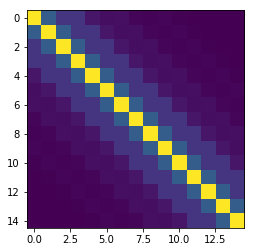

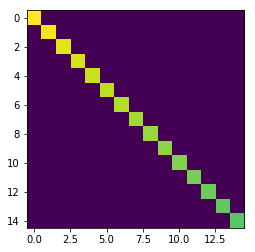

In [11]:
fV = fOp(V)
plt.imshow(abs(fV)[:15,:15])
plt.figure()
plt.imshow(abs(fT)[:15,:15])

[-1.63078762 -0.98978271 -0.92142074 -0.65471578 -0.50059523]
[-1.63479628 -0.99196617 -0.92812928 -0.66121683 -0.50715861]


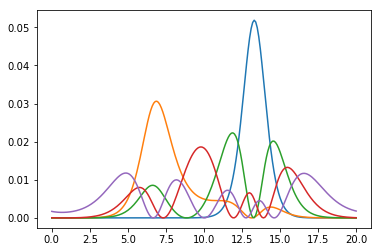

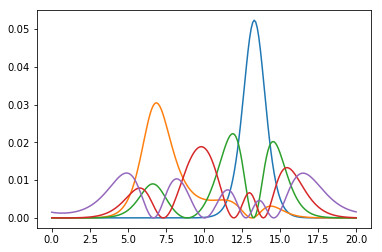

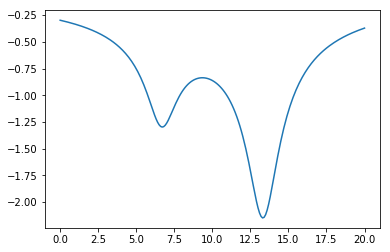

In [12]:
few, fev = np.linalg.eigh(fT + fV)
for i in range(5):
    plt.plot(x, abs(ifft(fev[:,i], norm='ortho'))**2)
print few[:5]

plt.figure()
ew, ev = np.linalg.eigh(T+V)
print ew[:5]
for i in range(5):
    plt.plot(x, ev[:,i]**2)
    
plt.figure()
plt.plot(x, np.diag(V))

**Note**: There are some problems with Fourier transform normalizations. It is strange that it is necessary to normalization by hand for fft, and use 'ortho' option for ifft.

# K-point sampling

When solving Schrodinger equation in reciprocal space, $q$ should cover the whole infinite real line $\mathbb{R}$. 
But we know if that $q$ and $q'$ differs by $n\:L$ ($L$ is the size of repeating cell and $n$ is some integer), they are identical due to periodicity. 
In other words, any point $q'$ in $\mathbb{R}$ can be expressed as a set of regular grid points $\{q_m:q_m\in [0,L)\}_{m=0}^{N-1}$ and a set of continuous k-points $\{k:0\leq k<L\}$ such that $q'=q_m+k+n\:L$ for some integers $m$ and $n$.
Moreover, $q+k+n\:L$ is identical to $q+k$ due to periodicity.

For the integrals involving $\langle q|\cdot|q'\rangle$, it is therefore resonable to define 
$$
\begin{array}{rcl}
q &=& q_m +k\\
q' &=& q_{m'} +k
\end{array}
$$

The potential operators, i.e $V, J, K$, we have $V(q-q') = V(q_m-q_{m'})$, which is $k$-independant. While for kinetic operator we have $k$-dependint $T(k) = \frac{1}{2}|q+k|^2$. 
As a result, we have a $k$-dependint Hamiltonian and the corresponding eigenvalues.

In [13]:
# setup k-mesh and the corresponding kinetic energy operator
q, q_shifted = q_grid(x)
k_mesh = q_shifted[::10]
fT_list = []
for k in k_mesh:
    fT = fT_from_x(x, k)
    fT_list.append(fT)

In [14]:
print k_mesh
print len(k_mesh)

[-31.57300617 -28.41570555 -25.25840493 -22.10110432 -18.9438037
 -15.78650308 -12.62920247  -9.47190185  -6.31460123  -3.15730062   0.
   3.15730062   6.31460123   9.47190185  12.62920247  15.78650308
  18.9438037   22.10110432  25.25840493  28.41570555  31.57300617]
21


[-1.34754264 -0.86237615 -0.57619241 -0.32540258 -0.02128256]
[-1.63059719 -0.98975648 -0.92124932 -0.65461477 -0.50052484]
[-1.63078755 -0.9897827  -0.92142069 -0.65471574 -0.50059515]
[-1.63078762 -0.98978271 -0.92142074 -0.65471578 -0.50059522]
[-1.63078762 -0.98978271 -0.92142074 -0.65471578 -0.50059522]
[-1.63078762 -0.98978271 -0.92142074 -0.65471578 -0.50059523]
[-1.63078762 -0.98978271 -0.92142074 -0.65471578 -0.50059523]
[-1.63078762 -0.98978271 -0.92142074 -0.65471578 -0.50059523]
[-1.63078762 -0.98978271 -0.92142074 -0.65471578 -0.50059523]
[-1.63078762 -0.98978271 -0.92142074 -0.65471578 -0.50059523]
[-1.63078762 -0.98978271 -0.92142074 -0.65471578 -0.50059523]
[-1.63078762 -0.98978271 -0.92142074 -0.65471578 -0.50059523]
[-1.63078762 -0.98978271 -0.92142074 -0.65471578 -0.50059523]
[-1.63078762 -0.98978271 -0.92142074 -0.65471578 -0.50059523]
[-1.63078762 -0.98978271 -0.92142074 -0.65471578 -0.50059523]
[-1.63078762 -0.98978271 -0.92142074 -0.65471578 -0.50059523]
[-1.6307

/home/samio/local/miniconda2/lib/python2.7/site-packages/matplotlib-2.0.0-py2.7-linux-x86_64.egg/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


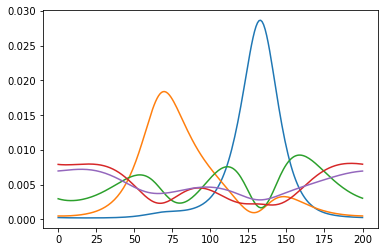

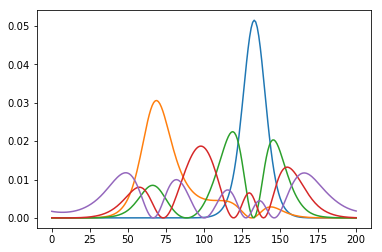

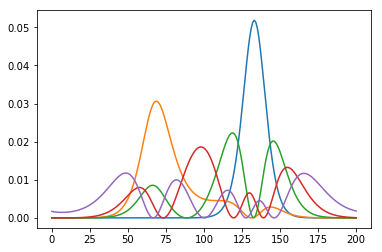

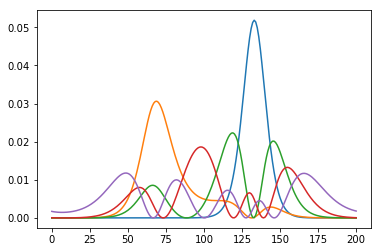

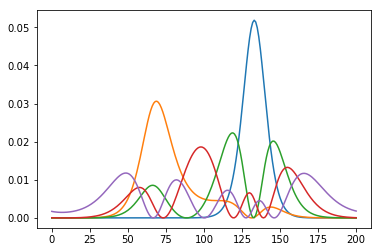

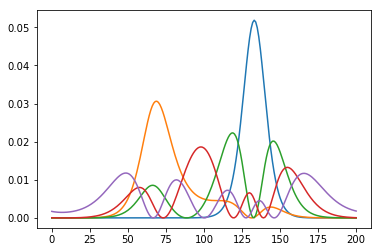

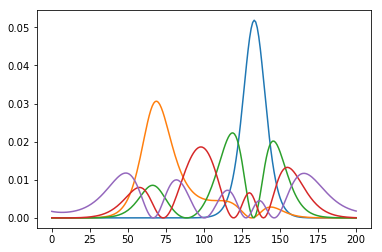

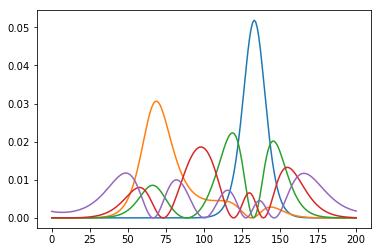

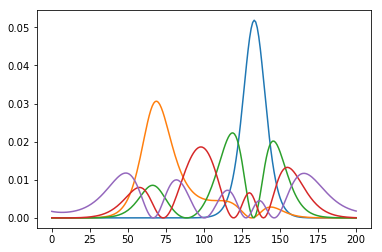

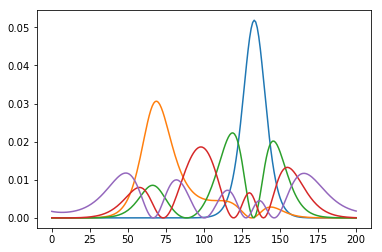

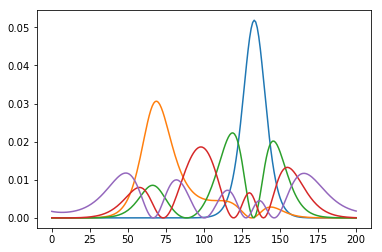

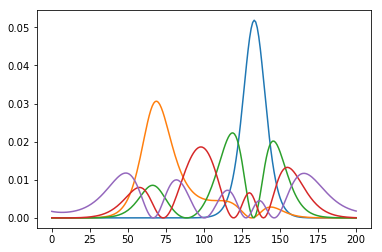

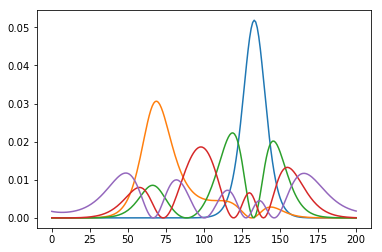

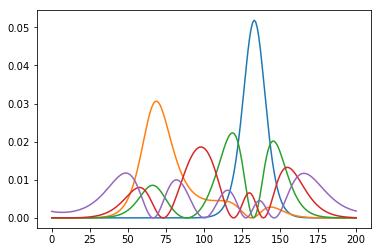

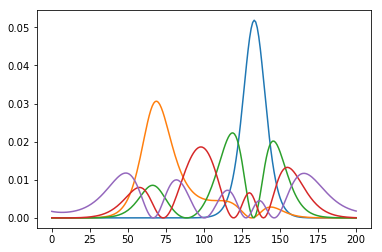

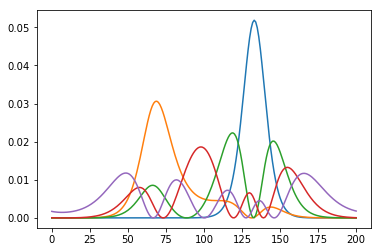

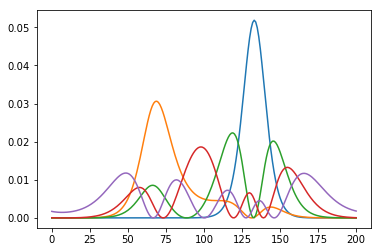

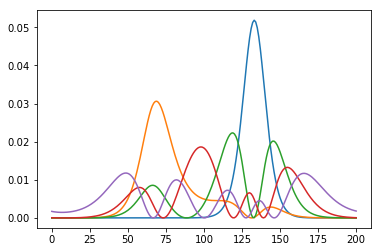

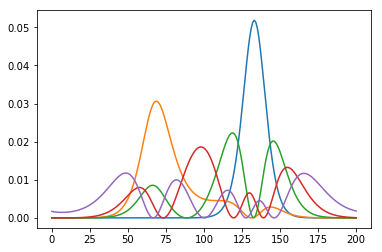

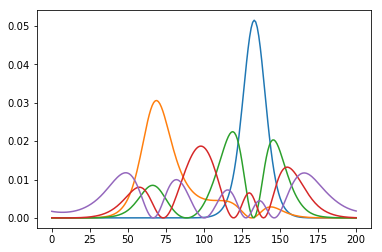

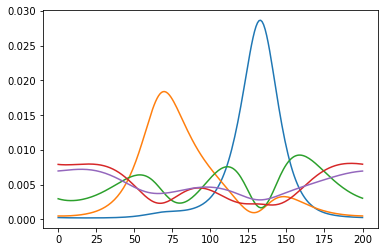

In [15]:
for fT in fT_list:
    few, fev = np.linalg.eigh(fT + fV)
    #plt.plot(np.diag(V))
    plt.figure()
    for i in range(5):
        plt.plot(abs(ifft(fev[:,i], norm='ortho'))**2)
    print few[:5]